# 🐄 COWLAR TASK (Part 1)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.decomposition import PCA

## 🗄️ Data Preprocessing

In [2]:
# Read all the lines from the file
with open('./fea.csv', 'r') as f:
    lines = f.readlines()

# Convert the lines into a 2D array
data = []
for line in lines:
    data.append([int(x) for x in line.strip().split(',')])

data = np.array(data)
data.shape

(1700, 1024)

In [3]:
# Create an array for labels
labels = []
for i in range(10):
    for j in range(170):
        labels.append(i)

labels = np.array(labels)
labels.shape

(1700,)

In [4]:
def createDataSplit(data, numOfTrainingSamples, numOfTestingSamples, numOfClasses=10):

    # Calculate the total number of samples
    numOfSamples = numOfTestingSamples + numOfTrainingSamples

    # Create empty arrays to store training and testing data
    trainingData = np.empty([0, data.shape[1]], dtype=data.dtype)
    testingData = np.empty([0, data.shape[1]], dtype=data.dtype)
    trainingLabels = []
    testingLabels = []


    for i in range(numOfClasses):

        # Randomly select test samples without replacement
        testChoices = np.random.choice(np.arange(numOfSamples * i, numOfSamples * (i + 1)), size=numOfTestingSamples, replace=False)
        
        # Generate training samples by excluding test samples
        trainChoices = np.array([k for k in range(i * numOfSamples, (i + 1) * numOfSamples) if k not in testChoices])
        
        ## Add training and testing data to respective arrays
        trainingData = np.vstack([trainingData, data[trainChoices]])
        testingData = np.vstack([testingData, data[testChoices]])

        # Add class labels to respective lists
        trainingLabels = trainingLabels + [i for k in range(numOfTrainingSamples)]
        testingLabels = testingLabels + [i for k in range(numOfTestingSamples)]

    trainingLabels = np.array(trainingLabels)
    testingLabels = np.array(testingLabels)

    return trainingData, testingData, trainingLabels, testingLabels

In [5]:
# normalize the images
normData = np.float32(data) / 255.0

# create the data splits with 150/20 split
dataSplits = {}
for i in range(5):
    dataSplits[i] = createDataSplit(normData, 150, 20)

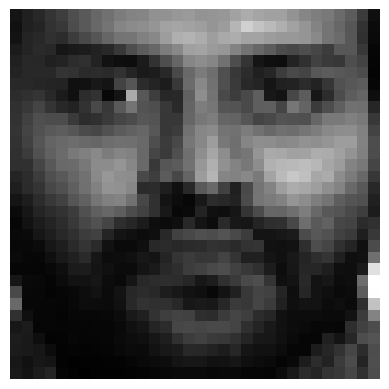

In [6]:
def viewImageFromFeatures(features):
    plt.imshow(features.reshape(32, 32).T, cmap='gray')
    plt.axis('off')

randImg = dataSplits[0][0][np.random.randint(0, 1500)]
viewImageFromFeatures(randImg)

## 🤖 k Nearest Neighbour

In [7]:
def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def cosine_similarity(point1, point2):
    point1, point2 = np.array(point1), np.array(point2)

    # Check if the points have the same dimensions
    if point1.shape != point2.shape:
        raise ValueError("Points must have the same dimensions")

    dot_prod = np.dot(point1, point2)
    norm_prod = np.linalg.norm(point1) * np.linalg.norm(point2)

    # Calculate the cosine similarity
    return dot_prod / norm_prod if norm_prod != 0 else 0

def mahalanobis_distance(point1, point2, inv_covariance):
    # Calculate the difference between the two points
    diff = point1 - point2
    
    # Calculate the Mahalanobis distance squared
    distance_squared = np.dot(np.dot(diff, inv_covariance), diff.T)
    
    return np.sqrt(distance_squared)

In [8]:
class kNN:
    def __init__(self, k, distanceMetric='euclidean'):
        self.k = k
        self.distMetric = distanceMetric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = []

        inv_covariance = np.linalg.inv(np.cov(self.X_train.T))

        # Iterate over each data point in X
        for i in range(X.shape[0]):
            distances = []
            # Calculate the distances between the current data point and all training data points
            for j in range(self.X_train.shape[0]):
                if self.distMetric == 'euclidean':
                    distances.append(euclidean_distance(X[i], self.X_train[j]))
                elif self.distMetric == 'cosine':
                    distances.append(cosine_similarity(X[i], self.X_train[j]))
                elif self.distMetric == 'mahalanobis':
                    distances.append(mahalanobis_distance(X[i], self.X_train[j], inv_covariance))

            # Sort the distances and get the indices of the k nearest neighbors
            if self.distMetric == 'euclidean':
                sorted_indices = np.argsort(distances)[:self.k]
            elif self.distMetric == 'cosine':
                sorted_indices = np.argsort(distances)[-self.k:]
            elif self.distMetric == 'mahalanobis':
                sorted_indices = np.argsort(distances)[:self.k]

            # Get the labels of the k nearest neighbors
            k_nearest_labels = self.y_train[sorted_indices]

            # Count the occurrences of each label
            unique, counts = np.unique(k_nearest_labels, return_counts=True)

            # Choose the label with the highest count as the predicted label
            y_pred.append(unique[np.argmax(counts)])

        return np.array(y_pred)

    def accuracy(self, y_pred, y_true):
        return np.sum(y_pred == y_true) / len(y_true)

### Using 150-20 Data Split

#### Using Euclidean Distance

In [ ]:
results = {}
for i in range(3, 16, 2):

    accs = []
    times = []

    for splitNum, split in dataSplits.items():

        X_train, X_test, y_train, y_test = split
        classifier = kNN(i)

        # Fit the classifier to the training data
        classifier.fit(X_train, y_train)

        # Measure the start time of prediction
        startTime = time.time()
        y_pred = classifier.predict(X_test)

        # Calculate the computation time for predictions
        endTime = time.time()
        computationTime = endTime - startTime

        accs.append(classifier.accuracy(y_pred, y_test))
        times.append(computationTime)
    
    # Store the results for k=i
    results[i] = {}
    results[i]['accAvg'] = round(np.mean(accs), 4)
    results[i]['accStd'] = round(np.std(accs), 4)
    results[i]['timeAvg'] = round(np.mean(times), 4)
    results[i]['timeStd'] = round(np.std(times), 4)

pd.DataFrame(results)

,3,5,7,9,11,13,15
accAvg,0.9650,0.9510,0.9130,0.9070,0.8880,0.8660,0.8580
accStd,0.0138,0.0156,0.0133,0.0068,0.0144,0.0146,0.0232
timeAvg,3.1801,3.5109,3.0246,3.0279,4.7490,3.0282,3.0341
timeStd,0.3998,0.6715,0.3461,0.3218,1.8890,0.3655,0.4836


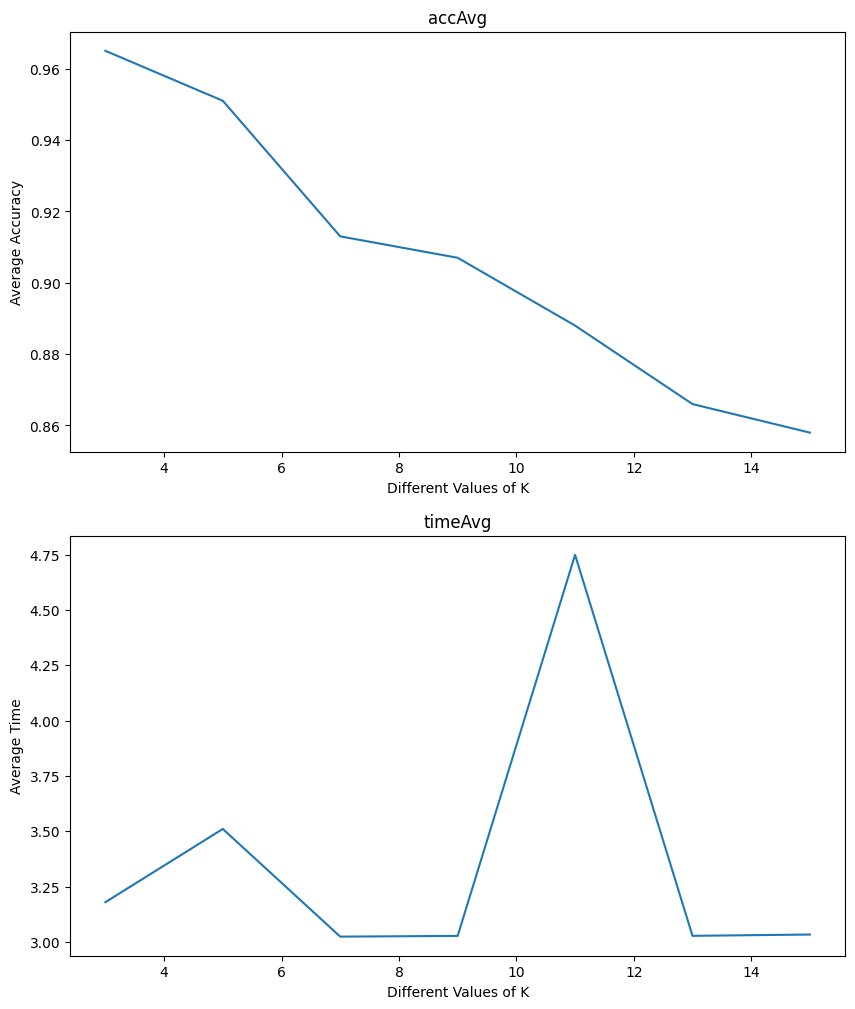

In [ ]:
results = pd.DataFrame(results).T
plt.figure(figsize=(10, 12))

# Iterate over the columns 'accAvg' and 'timeAvg'
for i, col in enumerate(['accAvg', 'timeAvg']):

    # Create a subplot for each column
    plt.subplot(2, 1, i + 1)
    plt.plot(results.index, results[col])
    plt.title(col)
    plt.xlabel('Different Values of K')
    plt.ylabel('Average Accuracy' if col == 'accAvg' else 'Average Time')

#### Using Cosine Similarity

In [ ]:
results = {}
for i in range(3, 16, 2):

    accs = []
    times = []

    for splitNum, split in dataSplits.items():

        X_train, X_test, y_train, y_test = split
        classifier = kNN(i, distanceMetric='cosine')

        # Fit the classifier to the training data
        classifier.fit(X_train, y_train)

        # Measure the start time of prediction
        startTime = time.time()
        y_pred = classifier.predict(X_test)

        # Calculate the computation time for predictions
        endTime = time.time()
        computationTime = endTime - startTime

        accs.append(classifier.accuracy(y_pred, y_test))
        times.append(computationTime)
    
    # Store the results for k=i
    results[i] = {}
    results[i]['accAvg'] = round(np.mean(accs), 4)
    results[i]['accStd'] = round(np.std(accs), 4)
    results[i]['timeAvg'] = round(np.mean(times), 4)
    results[i]['timeStd'] = round(np.std(times), 4)

pd.DataFrame(results)

,3,5,7,9,11,13,15
accAvg,0.9790,0.9630,0.9490,0.9400,0.9380,0.9270,0.9190
accStd,0.0058,0.0125,0.0086,0.0089,0.0081,0.0068,0.0146
timeAvg,6.0808,6.2539,6.4468,6.0668,6.3469,6.1189,6.0638
timeStd,0.6555,0.6116,0.6712,0.6196,0.6536,0.6245,0.3821


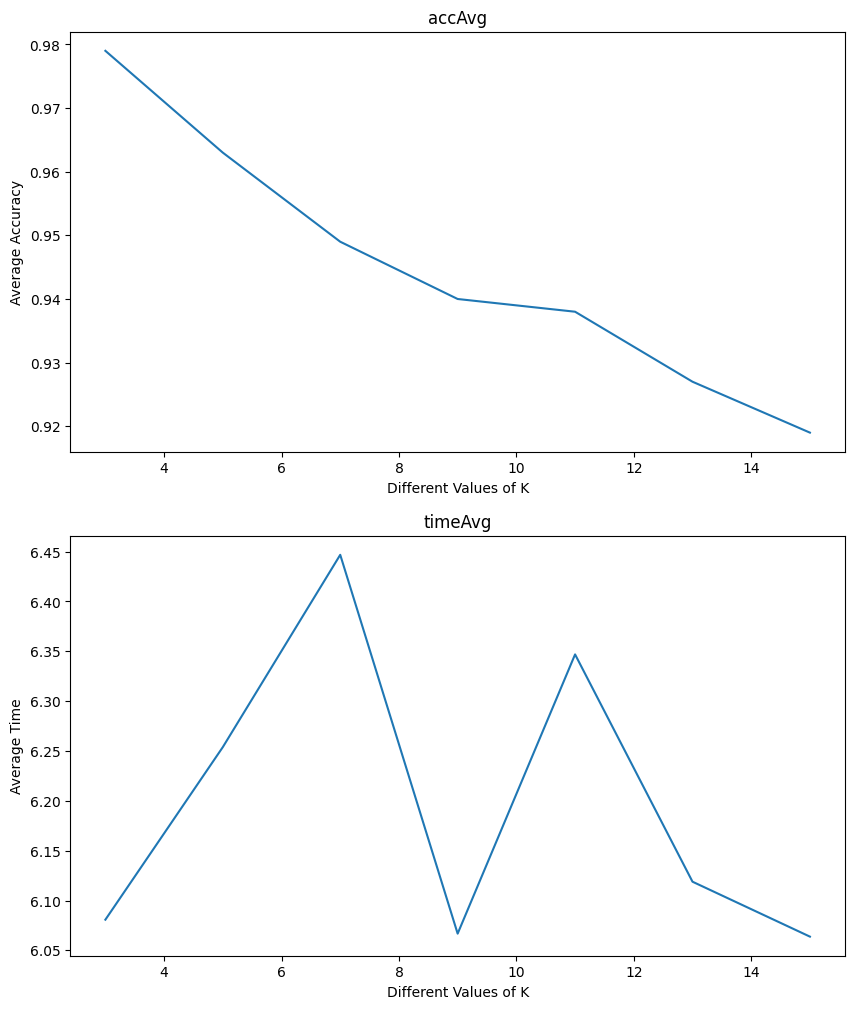

In [ ]:
results = pd.DataFrame(results).T
plt.figure(figsize=(10, 12))

# Iterate over the columns 'accAvg' and 'timeAvg'
for i, col in enumerate(['accAvg', 'timeAvg']):

    # Create a subplot for each column
    plt.subplot(2, 1, i + 1)
    plt.plot(results.index, results[col])
    plt.title(col)
    plt.xlabel('Different Values of K')
    plt.ylabel('Average Accuracy' if col == 'accAvg' else 'Average Time')

#### Using Mahalanobis

In [ ]:
results = {}
for i in range(3, 16, 2):

    accs = []
    times = []

    for splitNum, split in dataSplits.items():

        X_train, X_test, y_train, y_test = split
        classifier = kNN(i, distanceMetric='mahalanobis')

        # Fit the classifier to the training data
        classifier.fit(X_train, y_train)

        # Measure the start time of prediction
        startTime = time.time()
        y_pred = classifier.predict(X_test)

        # Calculate the computation time for predictions
        endTime = time.time()
        computationTime = endTime - startTime

        accs.append(classifier.accuracy(y_pred, y_test))
        times.append(computationTime)
    
    # Store the results for k=i
    results[i] = {}
    results[i]['accAvg'] = round(np.mean(accs), 4)
    results[i]['accStd'] = round(np.std(accs), 4)
    results[i]['timeAvg'] = round(np.mean(times), 4)
    results[i]['timeStd'] = round(np.std(times), 4)

pd.DataFrame(results)

,3,5,7,9,11,13,15
accAvg,0.8260,0.7460,0.6560,0.5650,0.4840,0.4330,0.3850
accStd,0.0139,0.0240,0.0296,0.0541,0.0426,0.0214,0.0243
timeAvg,109.8921,111.9665,108.7333,107.8883,108.9355,109.5639,110.3659
timeStd,4.9826,2.1468,5.0388,3.0117,3.3052,2.7194,3.5278


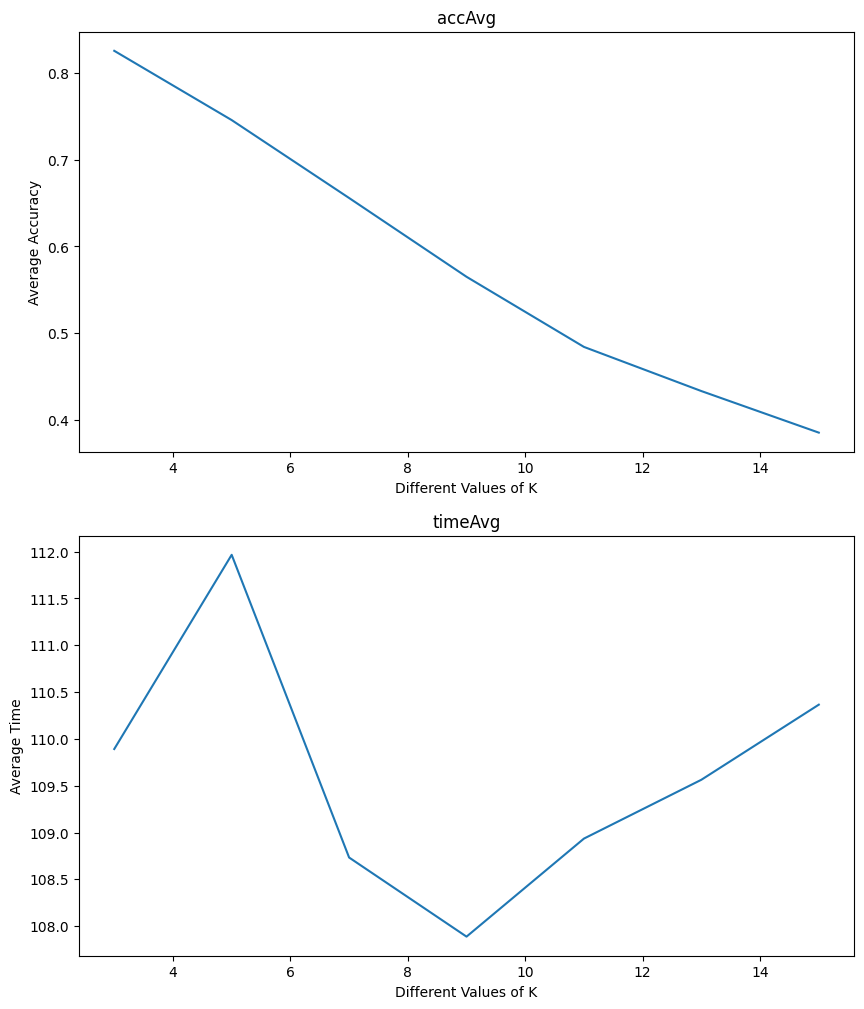

In [ ]:
results = pd.DataFrame(results).T
plt.figure(figsize=(10, 12))

# Iterate over the columns 'accAvg' and 'timeAvg'
for i, col in enumerate(['accAvg', 'timeAvg']):

    # Create a subplot for each column
    plt.subplot(2, 1, i + 1)
    plt.plot(results.index, results[col])
    plt.title(col)
    plt.xlabel('Different Values of K')
    plt.ylabel('Average Accuracy' if col == 'accAvg' else 'Average Time')

### Using 100-70 Data Split

In [ ]:
# create the data splits with 100/70 split
dataSplits2 = {}
for i in range(5):
    dataSplits2[i] = createDataSplit(normData, 100, 70)

#### Using Euclidean Distance

In [ ]:
results2 = {}
for i in range(3, 16, 2):

    accs = []
    times = []

    for splitNum, split in dataSplits2.items():

        X_train, X_test, y_train, y_test = split
        classifier = kNN(i)

        # Fit the classifier to the training data
        classifier.fit(X_train, y_train)

        # Measure the start time of prediction
        startTime = time.time()
        y_pred = classifier.predict(X_test)

        # Calculate the computation time for predictions
        endTime = time.time()
        computationTime = endTime - startTime
        accs.append(classifier.accuracy(y_pred, y_test))
        times.append(computationTime)
    
    # Store the results for k=i
    results2[i] = {}
    results2[i]['accAvg'] = round(np.mean(accs), 4)
    results2[i]['accStd'] = round(np.std(accs), 4)
    results2[i]['timeAvg'] = round(np.mean(times), 4)
    results2[i]['timeStd'] = round(np.std(times), 4)

pd.DataFrame(results2)

,3,5,7,9,11,13,15
accAvg,0.9069,0.8780,0.8434,0.8303,0.8066,0.7851,0.7623
accStd,0.0115,0.0131,0.0178,0.0210,0.0211,0.0202,0.0136
timeAvg,6.9746,6.9195,7.0780,7.1156,6.8071,7.0587,7.0584
timeStd,0.4844,0.5077,0.6104,0.4652,0.5612,0.4413,0.5795


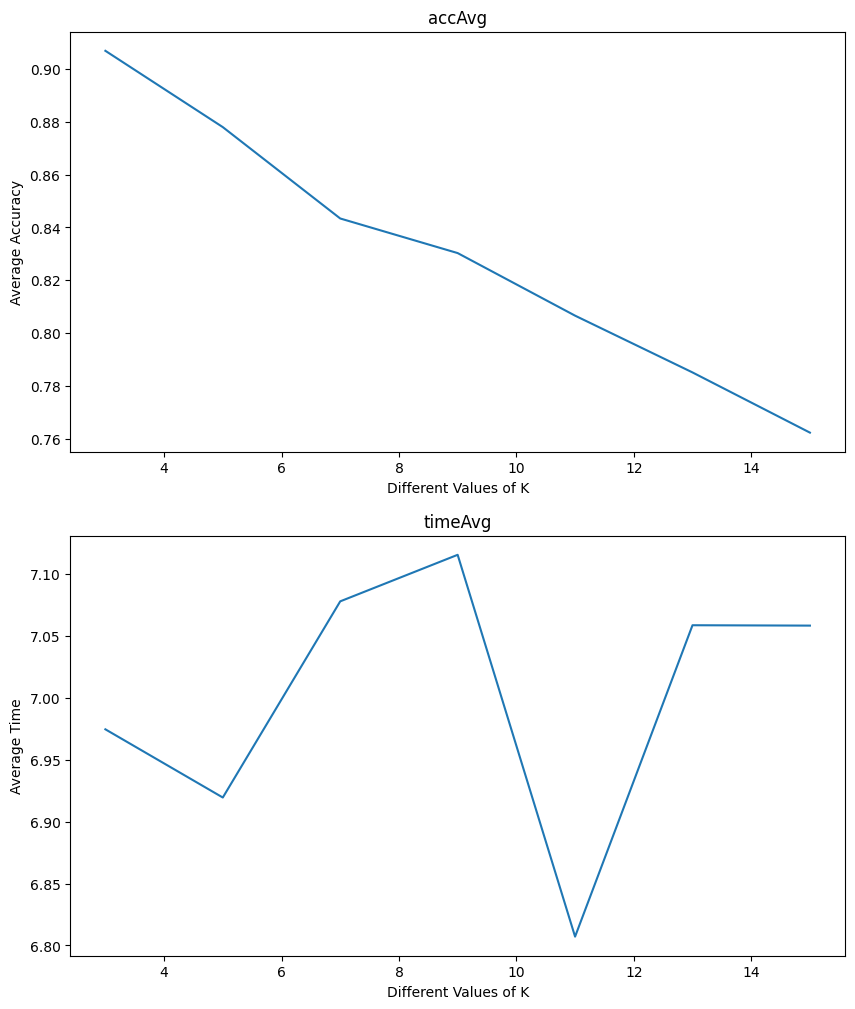

In [ ]:
results2 = pd.DataFrame(results2).T
plt.figure(figsize=(10, 12))

# Iterate over the columns 'accAvg' and 'timeAvg'
for i, col in enumerate(['accAvg', 'timeAvg']):
    
    # Create a subplot for each column
    plt.subplot(2, 1, i + 1)
    plt.plot(results2.index, results2[col])
    plt.title(col)
    plt.xlabel('Different Values of K')
    plt.ylabel('Average Accuracy' if col == 'accAvg' else 'Average Time')

#### Using Cosine Similarity

In [ ]:
results2 = {}
for i in range(3, 16, 2):

    accs = []
    times = []

    for splitNum, split in dataSplits2.items():

        X_train, X_test, y_train, y_test = split
        classifier = kNN(i, distanceMetric='cosine')

        # Fit the classifier to the training data
        classifier.fit(X_train, y_train)

        # Measure the start time of prediction
        startTime = time.time()
        y_pred = classifier.predict(X_test)

        # Calculate the computation time for predictions
        endTime = time.time()
        computationTime = endTime - startTime
        accs.append(classifier.accuracy(y_pred, y_test))
        times.append(computationTime)
    
    # Store the results for k=i
    results2[i] = {}
    results2[i]['accAvg'] = round(np.mean(accs), 4)
    results2[i]['accStd'] = round(np.std(accs), 4)
    results2[i]['timeAvg'] = round(np.mean(times), 4)
    results2[i]['timeStd'] = round(np.std(times), 4)

pd.DataFrame(results2)

,3,5,7,9,11,13,15
accAvg,0.9466,0.9289,0.9109,0.9037,0.8880,0.8823,0.8783
accStd,0.0064,0.0083,0.0055,0.0082,0.0114,0.0116,0.0100
timeAvg,12.8037,12.6641,12.6950,12.7485,12.5514,12.8099,12.5586
timeStd,0.3469,0.1612,0.0632,0.3037,0.0784,0.2644,0.1894


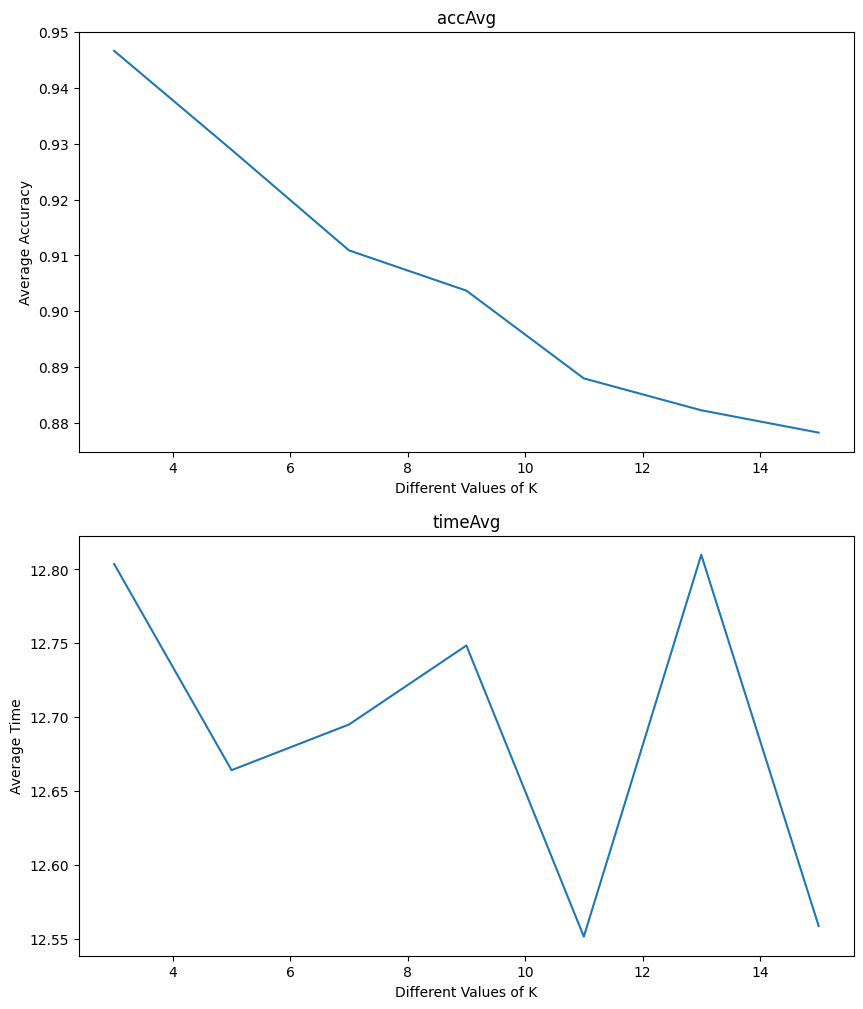

In [ ]:
results2 = pd.DataFrame(results2).T
plt.figure(figsize=(10, 12))

# Iterate over the columns 'accAvg' and 'timeAvg'
for i, col in enumerate(['accAvg', 'timeAvg']):
    
    # Create a subplot for each column
    plt.subplot(2, 1, i + 1)
    plt.plot(results2.index, results2[col])
    plt.title(col)
    plt.xlabel('Different Values of K')
    plt.ylabel('Average Accuracy' if col == 'accAvg' else 'Average Time')

#### Using Mahalanobis

In [9]:
# create the data splits with 100/70 split
dataSplits2 = {}
for i in range(5):
    dataSplits2[i] = createDataSplit(normData, 100, 70)

results2 = {}
for i in range(3, 16, 2):

    accs = []
    times = []

    for splitNum, split in dataSplits2.items():

        X_train, X_test, y_train, y_test = split
        classifier = kNN(i, distanceMetric='mahalanobis')

        # Fit the classifier to the training data
        classifier.fit(X_train, y_train)

        # Measure the start time of prediction
        startTime = time.time()
        y_pred = classifier.predict(X_test)

        # Calculate the computation time for predictions
        endTime = time.time()
        computationTime = endTime - startTime
        accs.append(classifier.accuracy(y_pred, y_test))
        times.append(computationTime)
    
    # Store the results for k=i
    results2[i] = {}
    results2[i]['accAvg'] = round(np.mean(accs), 4)
    results2[i]['accStd'] = round(np.std(accs), 4)
    results2[i]['timeAvg'] = round(np.mean(times), 4)
    results2[i]['timeStd'] = round(np.std(times), 4)

pd.DataFrame(results2)

<ipython-input-7-0e3d68a0b572>:24: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(distance_squared)


,3,5,7,9,11,13,15
accAvg,0.1009,0.0994,0.1020,0.1031,0.1029,0.0960,0.0946
accStd,0.0110,0.0130,0.0106,0.0100,0.0134,0.0111,0.0118
timeAvg,261.4043,269.8892,263.3929,260.1863,264.5089,257.8136,264.6933
timeStd,7.7627,25.1758,11.4147,9.9528,8.2517,6.8542,9.6414


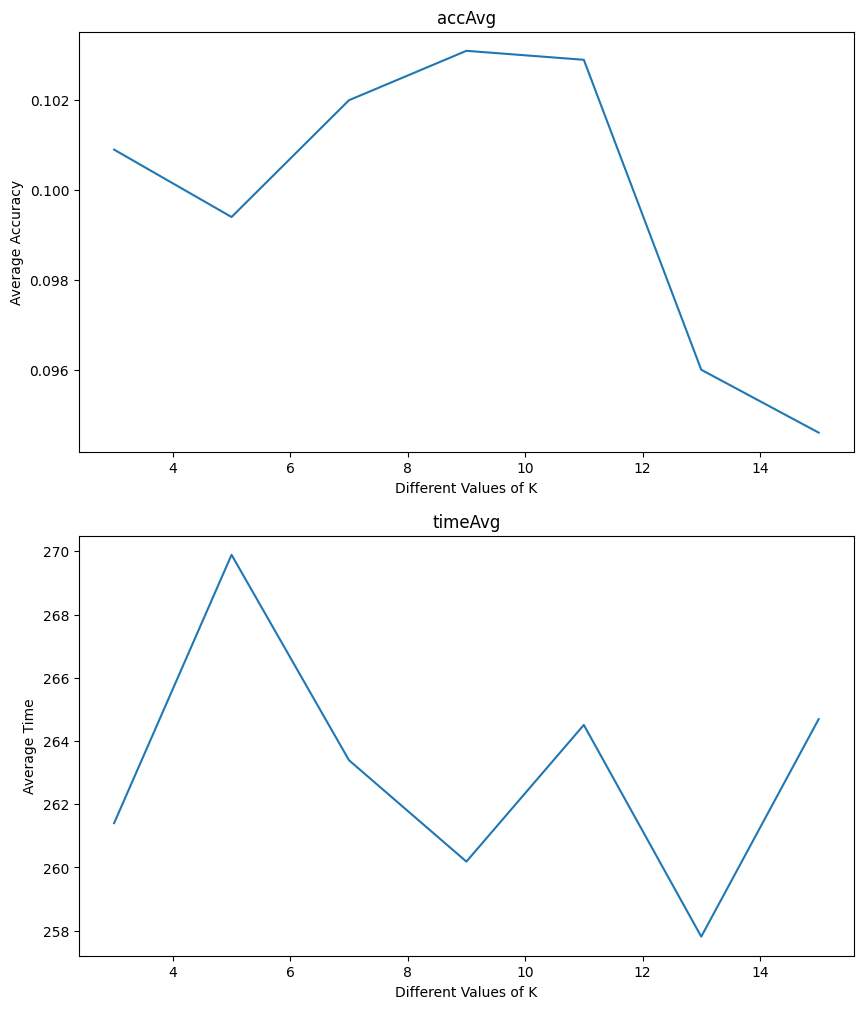

In [10]:
results2 = pd.DataFrame(results2).T
plt.figure(figsize=(10, 12))

# Iterate over the columns 'accAvg' and 'timeAvg'
for i, col in enumerate(['accAvg', 'timeAvg']):
    
    # Create a subplot for each column
    plt.subplot(2, 1, i + 1)
    plt.plot(results2.index, results2[col])
    plt.title(col)
    plt.xlabel('Different Values of K')
    plt.ylabel('Average Accuracy' if col == 'accAvg' else 'Average Time')

### Adding PCA to the Pipeline

In [9]:
# create the data splits with 150/20 split
dataSplits3 = {}
for i in range(5):
    dataSplits3[i] = createDataSplit(normData, 150, 20)

#### Using Euclidean Distance

In [ ]:
results3 = {}
i = 3 # since in previous results k=3 gave best results

for n in range(1024, 0, -64):

    accs = []
    times = []
    
    for splitNum, split in dataSplits.items():

        X_train, X_test, y_train, y_test = split

        # Apply PCA on the training and testing data
        pca = PCA(n_components=n)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        
        classifier = kNN(i)

        # Fit the classifier to the training data
        classifier.fit(X_train, y_train)

        # Measure the start time of prediction
        startTime = time.time()
        y_pred = classifier.predict(X_test)

        # Calculate the computation time for predictions
        endTime = time.time()
        computationTime = endTime - startTime
        accs.append(classifier.accuracy(y_pred, y_test))
        times.append(computationTime)
    
    # Store the results for n_components=n
    results3[n] = {}
    results3[n]['accAvg'] = round(np.mean(accs), 4)
    results3[n]['accStd'] = round(np.std(accs), 4)
    results3[n]['timeAvg'] = round(np.mean(times), 4)
    results3[n]['timeStd'] = round(np.std(times), 4)

pd.DataFrame(results3)

,1024,960,896,832,768,704,640,576,512,448,384,320,256,192,128,64
accAvg,0.9620,0.9620,0.9620,0.9620,0.9620,0.9620,0.9620,0.9620,0.9620,0.9620,0.9620,0.9630,0.9640,0.9620,0.9630,0.9630
accStd,0.0103,0.0103,0.0103,0.0103,0.0103,0.0103,0.0103,0.0103,0.0103,0.0103,0.0103,0.0093,0.0086,0.0068,0.0081,0.0103
timeAvg,3.3044,3.3707,3.3629,3.1547,2.8296,2.8669,2.7292,2.9436,2.7719,2.6902,2.6697,2.7715,2.4982,2.2596,2.2157,2.2540
timeStd,0.2603,0.3549,0.3650,0.2846,0.2093,0.3023,0.1798,0.3895,0.3318,0.2204,0.2699,0.3142,0.2157,0.2944,0.1501,0.3246


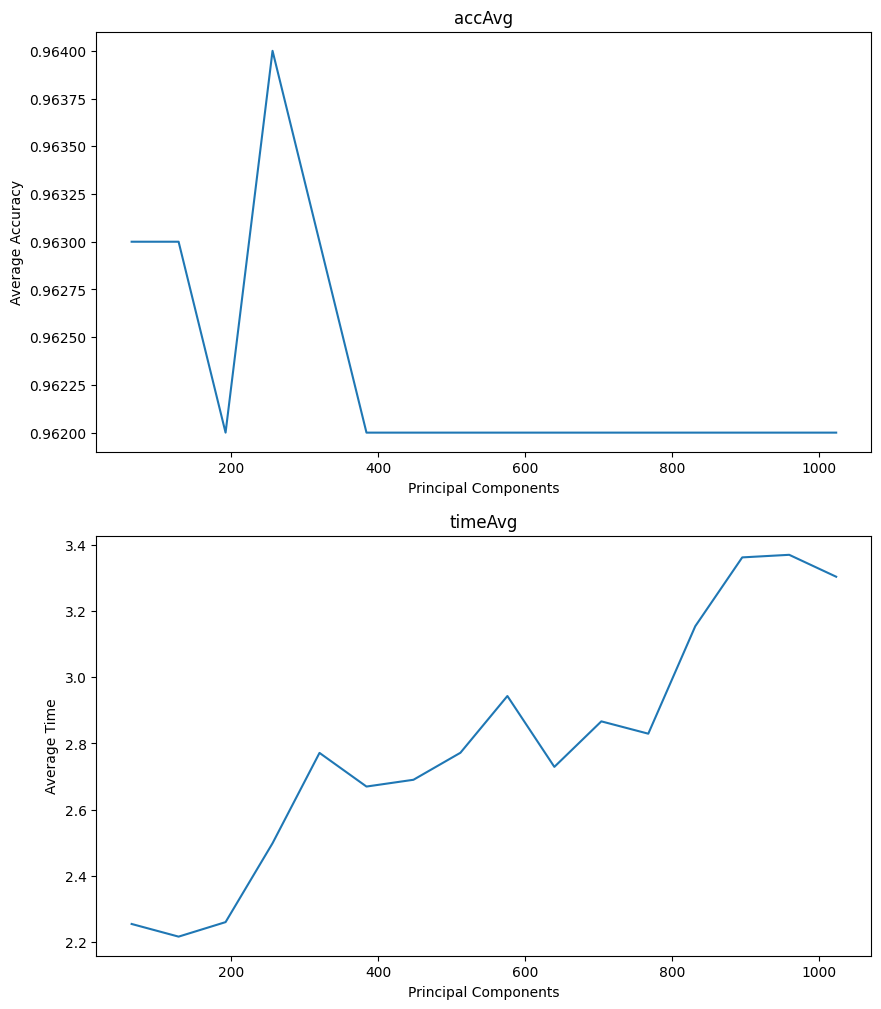

In [ ]:
results3 = pd.DataFrame(results3).T
plt.figure(figsize=(10, 12))

# Iterate over the columns 'accAvg' and 'timeAvg'
for i, col in enumerate(['accAvg', 'timeAvg']):
    
    # Create a subplot for each column
    plt.subplot(2, 1, i + 1)
    plt.plot(results3.index, results3[col])
    plt.title(col)
    plt.xlabel('Principal Components')
    plt.ylabel('Average Accuracy' if col == 'accAvg' else 'Average Time')

#### Using Cosine Similarity

In [10]:
results3 = {}
i = 3 # since in previous results k=3 gave best results

for n in range(1024, 0, -64):

    accs = []
    times = []
    
    for splitNum, split in dataSplits.items():

        X_train, X_test, y_train, y_test = split

        # Apply PCA on the training and testing data
        pca = PCA(n_components=n)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        
        classifier = kNN(i, distanceMetric='cosine')

        # Fit the classifier to the training data
        classifier.fit(X_train, y_train)

        # Measure the start time of prediction
        startTime = time.time()
        y_pred = classifier.predict(X_test)

        # Calculate the computation time for predictions
        endTime = time.time()
        computationTime = endTime - startTime
        accs.append(classifier.accuracy(y_pred, y_test))
        times.append(computationTime)
    
    # Store the results for n_components=n
    results3[n] = {}
    results3[n]['accAvg'] = round(np.mean(accs), 4)
    results3[n]['accStd'] = round(np.std(accs), 4)
    results3[n]['timeAvg'] = round(np.mean(times), 4)
    results3[n]['timeStd'] = round(np.std(times), 4)

pd.DataFrame(results3)

,1024,960,896,832,768,704,640,576,512,448,384,320,256,192,128,64
accAvg,0.9630,0.9630,0.9630,0.9630,0.9630,0.9630,0.9630,0.9630,0.9630,0.9640,0.9630,0.9630,0.9630,0.9630,0.9630,0.9640
accStd,0.0103,0.0103,0.0103,0.0103,0.0103,0.0103,0.0103,0.0103,0.0103,0.0097,0.0103,0.0103,0.0103,0.0103,0.0081,0.0066
timeAvg,8.1020,6.5844,6.6240,6.3649,6.1489,6.0600,5.9982,6.1615,5.8767,6.1139,5.7642,5.9398,5.4426,4.8439,4.8239,5.0879
timeStd,3.0342,0.5580,0.7011,0.5007,0.6250,0.5565,0.6808,0.5766,0.4570,0.6758,0.7086,0.5997,0.5851,0.5937,0.6518,0.6205


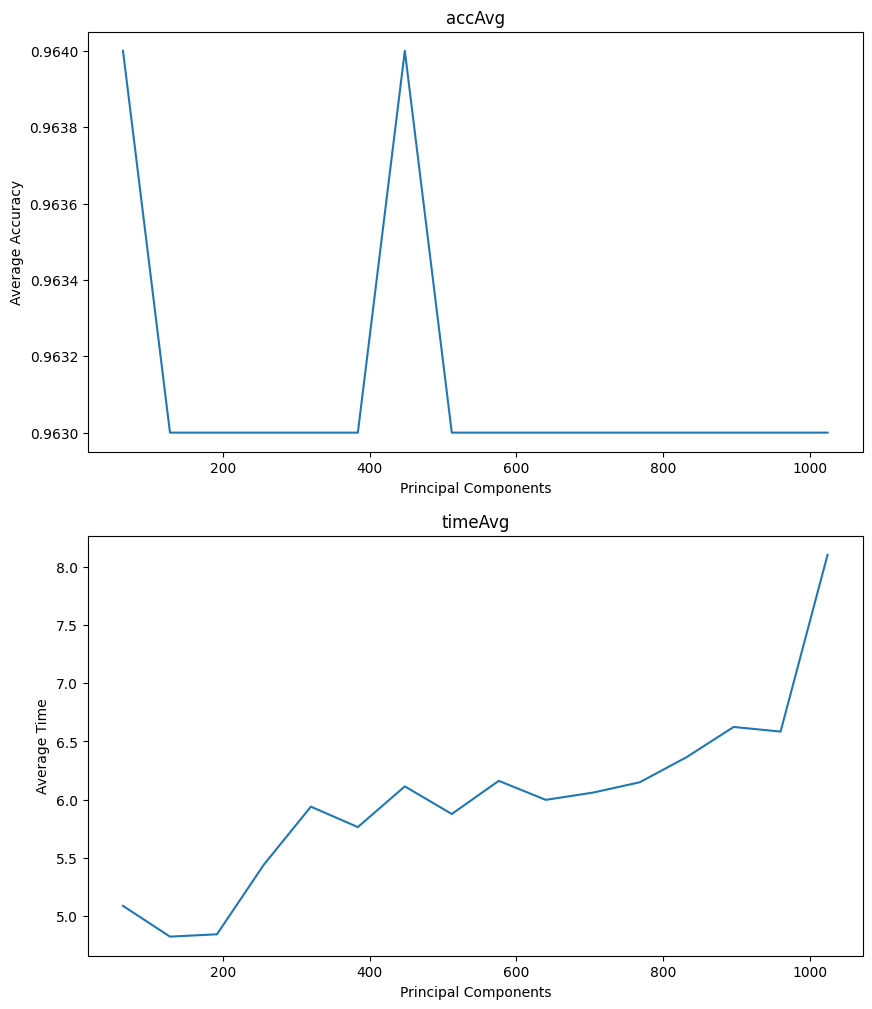

In [11]:
results3 = pd.DataFrame(results3).T
plt.figure(figsize=(10, 12))

# Iterate over the columns 'accAvg' and 'timeAvg'
for i, col in enumerate(['accAvg', 'timeAvg']):
    
    # Create a subplot for each column
    plt.subplot(2, 1, i + 1)
    plt.plot(results3.index, results3[col])
    plt.title(col)
    plt.xlabel('Principal Components')
    plt.ylabel('Average Accuracy' if col == 'accAvg' else 'Average Time')

#### Using Mahalanobis Distance

In [12]:
results3 = {}
i = 3 # since in previous results k=3 gave best results

for n in range(1024, 0, -64):

    accs = []
    times = []
    
    for splitNum, split in dataSplits.items():

        X_train, X_test, y_train, y_test = split

        # Apply PCA on the training and testing data
        pca = PCA(n_components=n)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        
        classifier = kNN(i, distanceMetric='mahalanobis')

        # Fit the classifier to the training data
        classifier.fit(X_train, y_train)

        # Measure the start time of prediction
        startTime = time.time()
        y_pred = classifier.predict(X_test)

        # Calculate the computation time for predictions
        endTime = time.time()
        computationTime = endTime - startTime
        accs.append(classifier.accuracy(y_pred, y_test))
        times.append(computationTime)
    
    # Store the results for n_components=n
    results3[n] = {}
    results3[n]['accAvg'] = round(np.mean(accs), 4)
    results3[n]['accStd'] = round(np.std(accs), 4)
    results3[n]['timeAvg'] = round(np.mean(times), 4)
    results3[n]['timeStd'] = round(np.std(times), 4)

pd.DataFrame(results3)

,1024,960,896,832,768,704,640,576,512,448,384,320,256,192,128,64
accAvg,0.8000,0.8110,0.8120,0.8310,0.8460,0.8590,0.8730,0.8970,0.9000,0.9080,0.9290,0.9420,0.9510,0.9530,0.9660,0.9700
accStd,0.0298,0.0233,0.0269,0.0278,0.0400,0.0307,0.0286,0.0189,0.0219,0.0279,0.0193,0.0133,0.0177,0.0121,0.0107,0.0138
timeAvg,105.0640,91.9839,84.1414,73.9587,63.0579,52.7771,46.1871,39.3219,33.0416,25.5362,19.7570,13.8973,9.8396,8.0183,6.3227,2.8570
timeStd,1.9621,2.2080,1.8374,0.9717,1.7790,1.6890,0.8039,0.9610,1.5805,0.4841,0.8721,1.1935,0.4298,0.3813,0.5005,0.3869


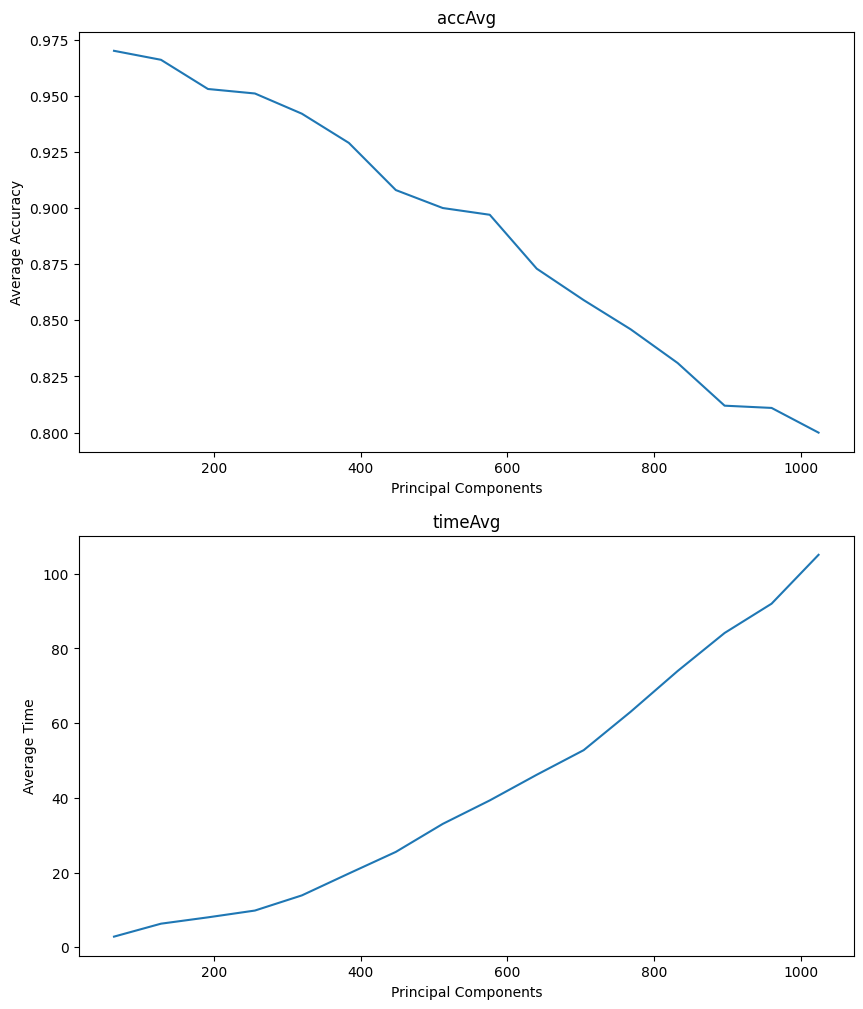

In [13]:
results3 = pd.DataFrame(results3).T
plt.figure(figsize=(10, 12))

# Iterate over the columns 'accAvg' and 'timeAvg'
for i, col in enumerate(['accAvg', 'timeAvg']):
    
    # Create a subplot for each column
    plt.subplot(2, 1, i + 1)
    plt.plot(results3.index, results3[col])
    plt.title(col)
    plt.xlabel('Principal Components')
    plt.ylabel('Average Accuracy' if col == 'accAvg' else 'Average Time')